#Transfer Learning for Computer Vision Tutorial

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
!unzip hymenoptera_data.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


##Importamos Librerias

In [2]:
!pip install torch


  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
    --------------------------------------- 4.2/216.1 MB 25.2 MB/s eta 0:00:09
   - -------------------------------------- 8.9/216.1 MB 24.0 MB/s eta 0:00:09
   -- ------------------------------------- 12.8/216.1 MB 21.2 MB/s eta 0:00:10
   --- ------------------------------------ 17.0/216.1 MB 21.1 MB/s eta 0:00:10
   --- ------------------------------------ 21.0/216.1 MB 20.7 MB/s eta 0:00:10
   ---- ----------------------------------- 24.4/216.1 MB 19.8 MB/s eta 0:00:10
   ----- ---------------------------------- 28.0/216.1 MB 19.3 MB/s eta 0:00:10
   ----- ---------------------------------- 32.0/216.1 MB 19.3 MB/s eta 0:00:10
   ------ --------------------------------- 34.9/216.1 MB 18.9 MB/s eta 0:00:10
   ------ --------------------------------- 37.5/216.1 MB 18.2 MB/s eta 0:00:10
   ------- -------------------------------- 39.6/216.1 MB 17.2 MB/s 

In [4]:
!pip install torchvision


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 13.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'torchvision'

##Cargar Datos

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Ver Imagenes


In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

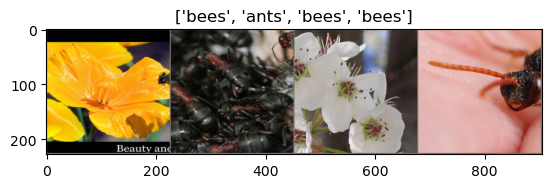

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

##Entrenando Modelo

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

##Visualización de las predicciones del modelo

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

##Ajuste

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

##Entrenar y evaluar

In [8]:
device

device(type='cuda', index=0)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.6406 Acc: 0.6967
val Loss: 0.8900 Acc: 0.6209

Training complete in 0m 35s
Best val Acc: 0.620915


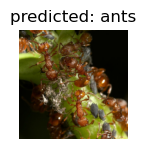

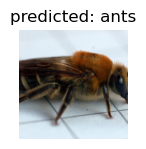

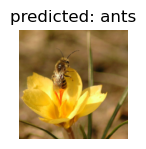

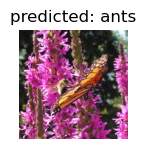

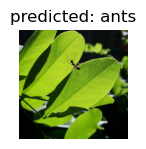

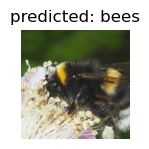

In [10]:
visualize_model(model_ft)


##extractor de características fijas

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

##Entrenar y evaluar

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4635 Acc: 0.7705
val Loss: 0.1994 Acc: 0.9150

Epoch 1/19
----------
train Loss: 0.3658 Acc: 0.8115
val Loss: 0.2893 Acc: 0.8889

Epoch 2/19
----------
train Loss: 0.6648 Acc: 0.7459
val Loss: 0.2784 Acc: 0.8693

Epoch 3/19
----------
train Loss: 0.5041 Acc: 0.8074
val Loss: 0.3235 Acc: 0.8758

Epoch 4/19
----------
train Loss: 0.5098 Acc: 0.7541
val Loss: 0.6168 Acc: 0.8039

Epoch 5/19
----------
train Loss: 0.5696 Acc: 0.7623
val Loss: 0.2290 Acc: 0.9085

Epoch 6/19
----------
train Loss: 0.4121 Acc: 0.8320
val Loss: 0.1762 Acc: 0.9542

Epoch 7/19
----------
train Loss: 0.3976 Acc: 0.8361
val Loss: 0.1741 Acc: 0.9542

Epoch 8/19
----------
train Loss: 0.3420 Acc: 0.8443
val Loss: 0.1695 Acc: 0.9542

Epoch 9/19
----------
train Loss: 0.3310 Acc: 0.8648
val Loss: 0.1906 Acc: 0.9542

Epoch 10/19
----------
train Loss: 0.3195 Acc: 0.8484
val Loss: 0.1804 Acc: 0.9477

Epoch 11/19
----------
train Loss: 0.3725 Acc: 0.8443
val Loss: 0.1702 Acc: 0.9542

Ep

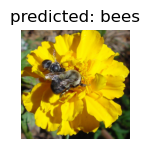

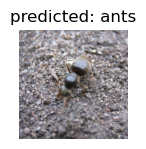

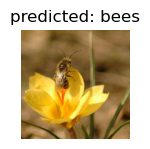

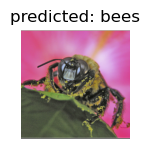

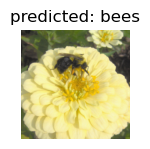

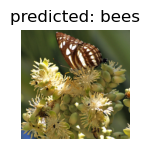

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##Inferencia sobre imágenes personalizadas

In [22]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

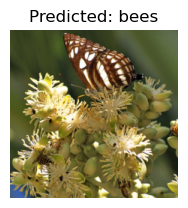

In [23]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()